In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdatesJ
from matplotlib.dates import DateFormatter

In [38]:
Etf=pd.read_csv('https://raw.githubusercontent.com/LinhTo11/Capstone/main/US%20Sector%20Inst%20ETF.csv?token=GHSAT0AAAAAABROZZ62LUZBZWCANVXWLXYGYQ6PCIA')
Institutional=pd.read_csv('https://raw.githubusercontent.com/LinhTo11/Capstone/main/US%20Sector%20Institutional%20MF.csv?token=GHSAT0AAAAAABROZZ627EZDQVMQKRV7VL5UYQ6PCPA') 
Retail=pd.read_csv('https://raw.githubusercontent.com/LinhTo11/Capstone/main/US%20Sector%20Retail%20MF.csv?token=GHSAT0AAAAAABROZZ62SVTK7JQNRR6372LUYQ6PCXQ')
sp500=pd.read_csv('https://raw.githubusercontent.com/LinhTo11/Capstone/main/sp500index.csv?token=GHSAT0AAAAAABROZZ63CQAUFDLJ2BUUKBNAYQ6PDAQ')

# VAR model

## Preprocessing data

We are going to group by AssetClass (19 in each dataset) and do this step for 3 datasets.

In [39]:
def preprocessing(df): 
  # trim AssetClass names
  df['AssetClass'] = df['AssetClass'].str.replace('-North America-USA-North America-Equity', '')

  # convert ReportDate to datetime 
  df['ReportDate'] = df['ReportDate'].map(lambda x: x.replace(' 12:00:00 AM', ''))
  df['ReportDate'] = pd.to_datetime(df['ReportDate'])
  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  # Drop where assetclass = infrastructure
  rows_to_drop = ['Infrastructure']
  condition_df = ~df["AssetClass"].isin(rows_to_drop)
  df = df[condition_df]
  return df

In [40]:
etf = preprocessing(Etf)
institutional = preprocessing(Institutional)
retail = preprocessing(Retail)


In [41]:
etf_statistics = etf.drop('AssetClass', axis = 1)
institutional_statistics = institutional.drop('AssetClass', axis = 1)
retail_statistics = retail.drop('AssetClass', axis = 1)

## Granger causality test

In [42]:
!pip install statsmodels

In [43]:
from statsmodels.tsa.stattools import grangercausalitytests

In [44]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
  """Check Granger Causality of all possible combinations of the Time series.
  The rows are the response variable, columns are predictors. The values in the table 
  are the P-Values. P-Values lesser than the significance level (0.05), implies 
  the Null Hypothesis that the coefficients of the corresponding past values is 
  zero, that is, the X does not cause Y can be rejected.

  data      : pandas dataframe containing the time series variables
  variables : list containing names of the time series variables.
  """
  df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in df.columns:
    for r in df.index:
      test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      df.loc[r, c] = min_p_value
  df.columns = [var + '_x' for var in variables]
  df.index = [var + '_y' for var in variables]
  return df

In [45]:
grangers_causation_matrix(etf_statistics, variables = etf_statistics.columns)

,Flow_x,FlowPct_x,AssetsEnd_x,PortfolioChangePct_x
Flow_y,1.0000,0.0000,0.7267,0.0000
FlowPct_y,0.0053,1.0000,0.5931,0.0000
AssetsEnd_y,0.4211,0.6336,1.0000,0.3292
PortfolioChangePct_y,0.3389,0.0000,0.0401,1.0000


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).


So, we can reject the null hypothesis and conclude all the other variables (time series) in the system are interchangeably causing each other.

## ADF test

In [46]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
def adf_test(df):
  adf1 = adfuller(df['FlowPct'], 12)
  print("Statistics analysis of FlowPct\n")
  print("Statistic Test:", adf1[0])
  print("p-value:", adf1[1])
  # print("n_lags:", adf[2])
  # print("Number of observation:", adf[3])
  # for key,value in adf[4].items():
  #     print(f" Critical value {key}: {value}")
  p_value = adf1[1]
  if p_value <= 0.05:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.\n")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.\n")

  adf2 = adfuller(df['PortfolioChangePct'], 12)
  print("Statistics analysis of PortfolioChangePct\n")
  print("Statistic Test:", adf2[0])
  print("p-value:", adf2[1])
  p_value = adf2[1]
  if p_value <= 0.05:
    print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
    print(f" => Series is Stationary.")
  else:
    print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
    print(f" => Series is Non-Stationary.")

In [47]:
adf_test(etf_statistics)

Statistics analysis of FlowPct

Statistic Test: -26.256112683583073
p-value: 0.0
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of PortfolioChangePct

Statistic Test: -20.958704082247245
p-value: 0.0
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [48]:
adf_test(institutional_statistics)

Statistics analysis of FlowPct

Statistic Test: -42.12045393857417
p-value: 0.0
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of PortfolioChangePct

Statistic Test: -20.72396350193041
p-value: 0.0
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [49]:
adf_test(retail_statistics)

Statistics analysis of FlowPct

Statistic Test: -101.29276520252593
p-value: 0.0
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

Statistics analysis of PortfolioChangePct

Statistic Test: -20.802680277868664
p-value: 0.0
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


We can conclude that all that data are stationary and ready for VAR model.

In [50]:
etf['AssetClass'].unique()

array(['Utilities', 'Commodities/Materials', 'Consumer Goods', 'Energy',
       'Financials', 'Health Care/Biotech', 'Industrials',
       'Large Cap Blend', 'Large Cap Growth', 'Telecom', 'Mid Cap Blend',
       'Technology', 'Small Cap Value', 'Small Cap Growth',
       'Large Cap Value', 'Real Estate', 'Mid Cap Value',
       'Mid Cap Growth', 'Small Cap Blend'], dtype=object)

In [51]:
def group_by_assetclass(df):

    arraysDict = {}
    grouped = df.groupby(df['AssetClass'])
    for i in df['AssetClass']:
        arraysDict['model_{0}'.format(i)] = grouped.get_group(i)


    return arraysDict

# carry-out the train-test split of the data and keep the last 10-weeks as test data.
def split(arraysDict, observations=10):
  global train
  global test
  train_dict = {}
  test_dict = {}
  for key in arraysDict.keys():
      # columns to drop and split train test sets
      arraysDict.get(key).drop('AssetClass', axis = 1, inplace = True)
      arraysDict.get(key).dropna()

      train_dict[key] = arraysDict.get(key).iloc[:-observations,:]
      test_dict[key] = arraysDict.get(key).iloc[-observations:,:]
  return train_dict, test_dict

In [52]:
arraysDict_etf = group_by_assetclass(etf)
arraysDict_institutional = group_by_assetclass(institutional)
arraysDict_retail = group_by_assetclass(retail)

In [53]:
train_etf_dict, test_etf_dict = split(arraysDict_etf)
train_institutional_dict, test_institutional_dict = split(arraysDict_institutional)
train_retail_dict, test_retail_dict = split(arraysDict_retail)
 

C:\Users\LinhTo\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## VAR model

In [54]:
from statsmodels.tsa.api import VAR

### Run model and fit model

In [55]:
# Run through Var model on every train set, put them in a list with a name
def run_model(train_dict):
    model_name = []
    model_list = []
    for key in train_dict.keys():
        model_list.append(VAR(train_dict.get(key)))
        model_name.append(key)
    # print(model_list)
    return model_name, model_list

# Fit the model and put them in a list, use lag 10
def fit_model(model_list):
    results = [i.fit(10) for i in model_list]
    return results


In [56]:
model_name_etf, model_list_etf = run_model(train_etf_dict)
model_name_institutional, model_list_institutional = run_model(train_institutional_dict)
model_name_retail, model_list_retail = run_model(train_retail_dict)

results_etf = fit_model(model_list_etf)
results_institutional = fit_model(model_list_institutional)
results_retail = fit_model(model_list_retail)

C:\Users\LinhTo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
C:\Users\LinhTo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
C:\Users\LinhTo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
C:\Users\LinhTo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  self._init_dates(dates, freq)
C:\Users\LinhTo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequen

### Get predictions

In [57]:
# Calculate lagged values of the train dataset
def lag(train_dict):
    lag_values = []
    for key in train_dict.keys():
        lag_values.append(train_dict.get(key).values[-10:])
    return lag_values

import itertools 
# Calculate result forecast of each lagged values with the fitted models, with steps = 10
def result_forecast(results, lag_values):
    predicted_results = []
    for (result, lag_value) in zip (results, lag_values):
        predicted_results.append(result.forecast (y = lag_value, steps = 10))
    return predicted_results

# In the predicted_results, there will be a list with 19 elements, each element is an array with shape (10,4).
# Take the 2nd column of that element, that is the predicted asset end
# This predicted asset end will have be an array with shape (0,10)

def get_predicted_assetend(predicted_results):
    predicted_assetends = []
    for predicted_result in predicted_results:
        predicted_assetends.append(predicted_result[:,2])
    return predicted_assetends

In [58]:
lag_values_etf = lag(train_etf_dict)
lag_values_institutional = lag(train_institutional_dict)
lag_values_retail = lag(train_retail_dict)

predicted_results_etf = result_forecast(results_etf, lag_values_etf)
predicted_results_institutional = result_forecast(results_institutional, lag_values_institutional)
predicted_results_retail = result_forecast(results_retail, lag_values_retail)

predicted_assetends_etf = get_predicted_assetend(predicted_results_etf)
predicted_assetends_institutional = get_predicted_assetend(predicted_results_institutional)
predicted_assetends_retail = get_predicted_assetend(predicted_results_retail)

### Evaluation

In [59]:
# Evaluate the forecasts by calculating the RMSE of predicted assetends and actual assetends in the test dataset
def get_actual_assetend(test_dict):
    actual_assetends = []
    for key in test_dict:
        actual_assetends.append(test_dict.get(key).loc[:, 'AssetsEnd'].values)
    return actual_assetends

def get_evaluation(predicted_assetends, actual_assetends):
    rmse = []
    for predicted_assetend, actual_assetend in zip(predicted_assetends, actual_assetends):
        rmse.append(np.mean((predicted_assetend - actual_assetend) ** 2) ** 0.5)
    return rmse
        

In [60]:
actual_assetends_etf = get_actual_assetend(test_etf_dict)
actual_assetends_institutional = get_actual_assetend(test_institutional_dict)
actual_assetends_retail = get_actual_assetend(test_retail_dict)

rmse_etf = get_evaluation(predicted_assetends_etf, actual_assetends_etf)
rmse_institutional = get_evaluation(predicted_assetends_institutional, actual_assetends_institutional)
rmse_retail = get_evaluation(predicted_assetends_retail, actual_assetends_retail)


### RMSE table for each asset end

In [61]:
data = {'Etf': rmse_etf, 'Institutional': rmse_institutional, 'Retail' : rmse_retail}
rmse_table = pd.DataFrame(data = data, index = model_name_etf)
rmse_table

,Etf,Institutional,Retail
model_Utilities,474.596794,520.492189,507.022275
model_Commodities/Materials,772.531578,780.869927,1518.367724
model_Consumer Goods,506.168203,506.168203,427.763661
model_Energy,2866.351007,3746.659685,407.730242
model_Financials,7563.592719,7901.087323,3679.640531
model_Health Care/Biotech,1237.765558,1507.716637,2148.870298
model_Industrials,1638.702082,1638.702082,7072.263693
model_Large Cap Blend,27548.340956,35955.874543,3166.253988
model_Large Cap Growth,6815.695258,5146.783731,25.207800
model_Telecom,331.452947,331.452947,958.989012


In [62]:
import matplotlib as plt
import seaborn as sns

Text(0.5, 1.0, 'VAR model with assetend prediction on each assetclass')

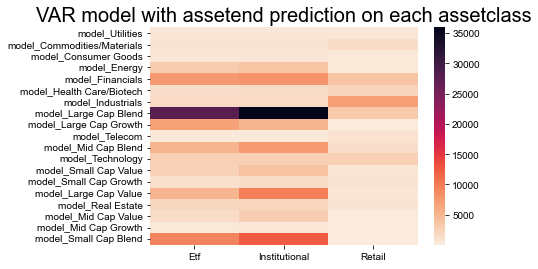

In [63]:
# rmse_table = sns.load_dataset("rmse_table")
# rmse_table = rmse_table.pivot("month", "year", "passengers")

cmap = sns.cm.rocket_r
ax = sns.heatmap(rmse_table,cmap = cmap)
sns.set(rc = {'figure.figsize':(10,8)})
ax.set_title('VAR model with assetend prediction on each assetclass', fontsize =20)